**Imports**

In [2]:
import json 
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm

**Load Data**

In [2]:
train_data_dir = Path("../data/train")
test_data_dir = Path("../data/test")

train_json_files = list((train_data_dir / "annotations").glob("*.json"))
test_json_files = list((test_data_dir / "annotations").glob("*.json"))

**Export Desired Data**

In [3]:
col_names = ['image_path', 'image_size', 'image_class', 'texts']

def get_annot_df(files, split='train'):
    annot_df = pd.DataFrame(columns=col_names)
    root_dir = f"./data/{split}/images/"

    for i, file in enumerate(tqdm(files)):       
        with open(file) as f:
            d = json.load(f)
        contents = [root_dir+d['images'][0]['name'], (d['images'][0]['height'],d['images'][0]['width']), d['images'][0]['class'],
                    [(x['type'], x['text']) for x in d['annotations'][0]['polygons']]]
        annot_df.loc[i] = contents
    return annot_df

In [4]:
train_annot_df = get_annot_df(train_json_files, split="train")
test_annot_df = get_annot_df(test_json_files, split="test")

100%|██████████| 21044/21044 [01:19<00:00, 265.06it/s]


**Data Cleansing**

In [5]:
uni_texts = []
for item in train_annot_df.texts:
    uni_texts += [text for type, text in item if type==0]

pd.Series(uni_texts).value_counts()

                   126733
                       33
·                       8
R                       8
식품의약품안전처                7
                    ...  
POLYGLYCERYL-6          1
OIL                     1
SEED                    1
ESTERSBEHENATE,         1
.                       1
Name: count, Length: 483, dtype: int64

In [6]:
def drop_unitext(container):
    return [(type, text) for type, text in container if type != 0 or type + len(text.strip())]

In [7]:
train_annot_df['texts'] = train_annot_df.loc[:,'texts'].apply(lambda x: drop_unitext(x))
test_annot_df['texts'] = test_annot_df.loc[:,'texts'].apply(lambda x: drop_unitext(x))

In [8]:
uni_texts_modified = []
for item in train_annot_df.texts:
    uni_texts_modified += [text for type, text in item if type==0]

pd.Series(uni_texts_modified).value_counts()

·                  8
R                  8
BAYER              7
식품의약품안전처           7
la                 6
                  ..
OIL                1
SEED               1
ESTERSBEHENATE,    1
POLYGLYCERYL-2     1
.                  1
Name: count, Length: 479, dtype: int64

In [9]:
train_annot_df.to_csv("../dataframes/train_annot_df.csv", index=False)
test_annot_df.to_csv("../dataframes/test_annot_df.csv", index=False)

**Plotting Image Sizes**

In [3]:
train_df = pd.read_csv("../dataframes/train_annot_df.csv")

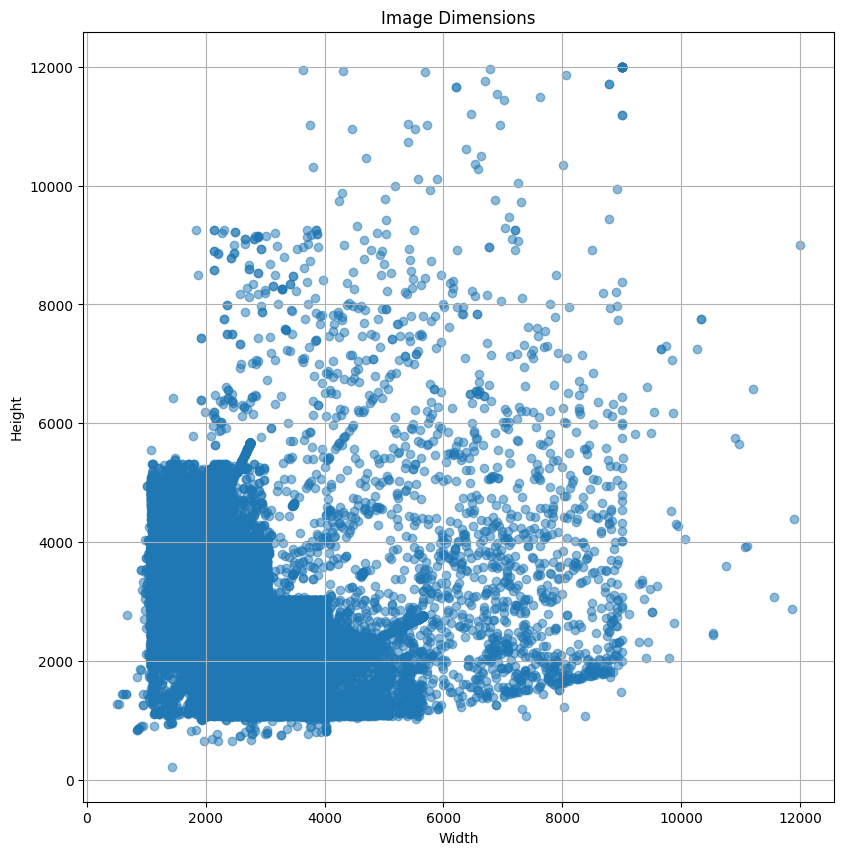

In [4]:
plt.figure(figsize=(10, 10))

plt.scatter(x=train_df['image_size'].apply(lambda x: eval(x)[1]), y=train_df['image_size'].apply(lambda x: eval(x)[0]), marker="o", alpha=0.5)

# Add axis labels
plt.xlabel("Width")
plt.ylabel("Height")

# Add a title
plt.title("Image Dimensions")

# Add gridlines
plt.grid(True)

# Set aspect ratio to be equal
plt.gca().set_aspect("equal", adjustable="box")

# Show the plot
plt.show()

In [6]:
print(f"Most Frequent Height: {train_df['image_size'].apply(lambda x: eval(x)[0]).mode()[0]}")
print(f"Most Frequent Width: {train_df['image_size'].apply(lambda x: eval(x)[1]).mode()[0]}")
print(f"Most Frequent Set: {train_df['image_size'].mode()[0]}")
print(f"Most Frequent Ratio: {pd.Series(train_df['image_size'].apply(lambda x: eval(x)[0] / eval(x)[1])).mode()[0]}")

Most Frequent Height: 4032
Most Frequent Width: 4032
Most Frequent Set: (4032, 3024)
Most Frequent Ratio: 1.0


**Plotting Sequence Lengths**

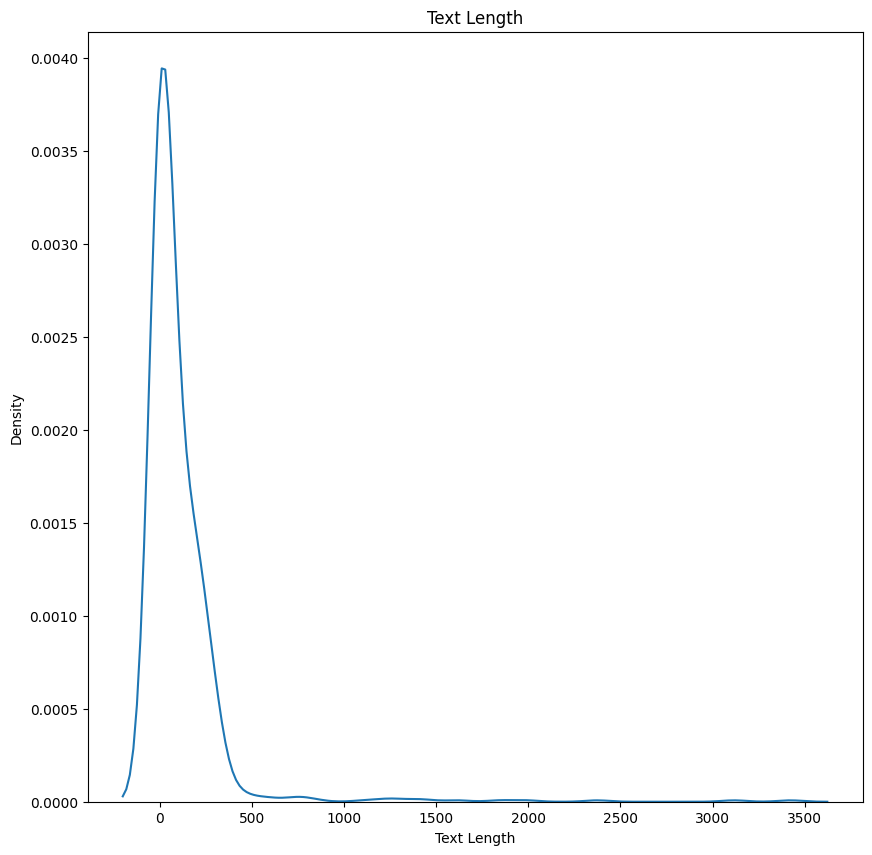

In [11]:
lengths =train_df['texts'].apply(lambda x: len(eval(x)))
frequency =lengths.value_counts().sort_index()

plt.figure(figsize=(10, 10))

sns.kdeplot(frequency)

# Add axis labels
plt.xlabel("Text Length")
plt.ylabel("Density")

# Add a title
plt.title("Text Length")

# Show the plot
plt.show()

In [13]:
lengths.describe()

count    84172.000000
mean       112.327294
std        121.063777
min          0.000000
25%         12.000000
50%         74.000000
75%        178.000000
max       1475.000000
Name: texts, dtype: float64

In [14]:
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1

upper_whisker = Q3 + (1.5 * IQR)

print(f"Upper Whisker : {upper_whisker}")

Upper Whisker : 427.0


In [15]:
print(f"Number of Truncated Texts : {len(lengths[lengths>1024])}")

Number of Truncated Texts : 31


**Determining Image Size on regard of Sequence Length**

In [16]:
text_lengths = train_df['texts'].apply(lambda x: len(eval(x)))
threshold = np.percentile(text_lengths, 50)
print(f"Most Frequent Ratio with Length above Threshold: {pd.Series(train_df[text_lengths >= threshold]['image_size'].apply(lambda x: eval(x)[0] / eval(x)[1])).mode()[0]}")

Most Frequent Ratio with Length above Threshold: 1.3333333333333333
